# AutoMM for Image + Text + Tabular - Quick Start

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/autogluon/autogluon/blob/stable/docs/tutorials/multimodal/multimodal_prediction/beginner_multimodal.ipynb)
[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/autogluon/autogluon/blob/stable/docs/tutorials/multimodal/multimodal_prediction/beginner_multimodal.ipynb)



AutoMM is a deep learning "model zoo" of model zoos. It can automatically build deep learning models that are suitable for multimodal datasets. You will only need to convert the data into the multimodal dataframe format
and AutoMM can predict the values of one column conditioned on the features from the other columns including images, text, and tabular data.

In [ ]:
!pip install autogluon.multimodal

  Using cached torch-2.3.1-cp310-cp310-manylinux1_x86_64.whl.metadata (26 kB)
Using cached torch-2.3.1-cp310-cp310-manylinux1_x86_64.whl (779.1 MB)


In [ ]:
!pip install autogluon
!pip install torch torchvision torchaudio transformers

  Using cached torchaudio-2.4.1-cp310-cp310-manylinux1_x86_64.whl.metadata (6.4 kB)
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
  Using cached torchaudio-2.4.0-cp310-cp310-manylinux1_x86_64.whl.metadata (6.4 kB)
  Using cached torchaudio-2.3.1-cp310-cp310-manylinux1_x86_64.whl.metadata (6.4 kB)
Using cached torchaudio-2.3.1-cp310-cp310-manylinux1_x86_64.whl (3.3 MB)


In [ ]:
!pip uninstall torch torchaudio -y
!pip install torch torchvision torchaudio

Found existing installation: torch 2.3.1
Uninstalling torch-2.3.1:
  Successfully uninstalled torch-2.3.1
Found existing installation: torchaudio 2.3.1
Uninstalling torchaudio-2.3.1:
  Successfully uninstalled torchaudio-2.3.1
  Using cached torch-2.4.1-cp310-cp310-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached torchaudio-2.4.1-cp310-cp310-manylinux1_x86_64.whl.metadata (6.4 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached triton-3.0.0-1-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.3 kB)
  Using cached torch-2.3.1-cp310-cp310-manylinux1_x86_64.whl.metadata (26 kB)
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
  Using cached torchaudio-2.4.0-cp310-cp310-manylinux1_x86_64.whl.metadata (6.4 kB)
  Using cached torchaudio-2.3.1-cp310-cp310-manylinux1_x86_64.whl.metadata (6.4 kB)
Using cached torc

In [ ]:
!pip install autogluon --upgrade

## Dataset

For demonstration, we use a simplified and subsampled version of [PetFinder dataset](https://www.kaggle.com/c/petfinder-adoption-prediction). The task is to predict the animals' adoption rates based on their adoption profile information. In this simplified version, the adoption speed is grouped into two categories: 0 (slow) and 1 (fast).

To get started, let's download and prepare the dataset.

In [ ]:
download_dir = './ag_automm_tutorial'
zip_file = 'https://automl-mm-bench.s3.amazonaws.com/petfinder_for_tutorial.zip'
from autogluon.core.utils.loaders import load_zip
load_zip.unzip(zip_file, unzip_dir=download_dir)

100%|██████████| 18.8M/18.8M [00:01<00:00, 17.2MiB/s]


Next, we will load the CSV files.

In [ ]:
import pandas as pd
dataset_path = download_dir + '/petfinder_for_tutorial'
train_data = pd.read_csv(f'{dataset_path}/train.csv', index_col=0)
test_data = pd.read_csv(f'{dataset_path}/test.csv', index_col=0)
label_col = 'AdoptionSpeed'

We need to expand the image paths to load them in training.

In [ ]:
import pandas as pd
import os
image_col = 'Images'
train_data[image_col] = train_data[image_col].apply(lambda ele: ele.split(';')[0]) # Use the first image for a quick tutorial
test_data[image_col] = test_data[image_col].apply(lambda ele: ele.split(';')[0])


def path_expander(path, base_folder):
    path_l = path.split(';')
    return ';'.join([os.path.abspath(os.path.join(base_folder, path)) for path in path_l])

train_data[image_col] = train_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))
test_data[image_col] = test_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))

train_data[image_col].iloc[0]

'/content/ag_automm_tutorial/petfinder_for_tutorial/images/7d7a39d71-1.jpg'

Each animal's adoption profile includes pictures, a text description, and various tabular features such as age, breed, name, color, and more. Let's look at an example row of data and display the text description and a picture.

In [ ]:
example_row = train_data.iloc[1]

example_row

,1
Type,2
Name,Nene/ Kimie
Age,12
Breed1,285
Breed2,0
Gender,2
Color1,5
Color2,6
Color3,7
MaturitySize,2


In [ ]:
example_row['Description']

'Has adopted by a friend with new pet name Kimie'

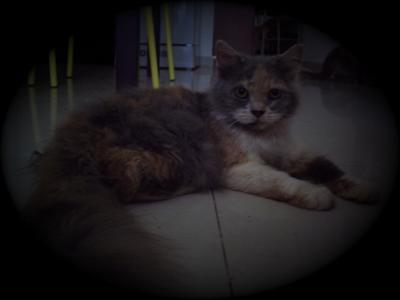

In [ ]:
example_image = example_row[image_col]

from IPython.display import Image, display
pil_img = Image(filename=example_image)
display(pil_img)

## Training
Now let's fit the predictor with the training data. Here we set a tight time budget for a quick demo.

In [ ]:
from autogluon.multimodal import MultiModalPredictor
predictor = MultiModalPredictor(label=label_col)
predictor.fit(
    train_data=train_data,
    time_limit=120, # seconds
)

No path specified. Models will be saved in: "AutogluonModels/ag-20240926_082038"
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Pytorch Version:    2.3.1+cu121
CUDA Version:       12.1
Memory Avail:       10.43 GB / 12.67 GB (82.3%)
Disk Space Avail:   189.67 GB / 235.68 GB (80.5%)
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])

AutoMM starts to create your model. ✨✨✨

To track the learning progress, you can open a terminal and launch Tensorboard:
    ```shell
    # Assume you have install

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/395M [00:00<?, ?B/s]

GPU Count: 1
GPU Count to be Used: 1
GPU 0 Name: Tesla T4
GPU 0 Memory: 0.25GB/15.0GB (Used/Total)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name              | Type                | Params | Mode 
------------------------------------------------------------------
0 | model             | MultimodalFusionMLP | 207 M  | train
1 | validation_metric | BinaryAUROC         | 0      | train
2 | loss_func         | CrossEntropyLoss    | 0      | train
------------------------------------------------------------------
207 M     Trainable params
0         Non-trainable params
207 M     Total params
828.307   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 1: 'val_roc_auc' reached 0.56194 (best 0.56194), saving model to '/content/AutogluonModels/ag-20240926_082038/epoch=0-step=1.ckpt' as top 3
INFO: Time limit reached. Elapsed time is 0:02:07. Signaling Trainer to stop.


Validation: |          | 0/? [00:00<?, ?it/s]

AutoMM has created your model. 🎉🎉🎉

To load the model, use the code below:
    ```python
    from autogluon.multimodal import MultiModalPredictor
    predictor = MultiModalPredictor.load("/content/AutogluonModels/ag-20240926_082038")
    ```

If you are not satisfied with the model, try to increase the training time, 
adjust the hyperparameters (https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html),
or post issues on GitHub (https://github.com/autogluon/autogluon/issues).




Under the hood, AutoMM automatically infers the problem type (classification or regression), detects the data modalities, selects the related models from the multimodal model pools, and trains the selected models. If multiple backbones are available, AutoMM appends a late-fusion model (MLP or transformer) on top of them.


## Evaluation
Then we can evaluate the predictor on the test data.

In [ ]:
scores = predictor.evaluate(test_data, metrics=["roc_auc"])
scores

Predicting: |          | 0/? [00:00<?, ?it/s]

{'roc_auc': 0.6052000000000001}

## Prediction
Given a multimodal dataframe without the label column, we can predict the labels.

In [ ]:
predictions = predictor.predict(test_data.drop(columns=label_col))
predictions[:5]

Predicting: |          | 0/? [00:00<?, ?it/s]

,AdoptionSpeed
8,0
70,0
82,1
28,1
63,1


For classification tasks, we can get the probabilities of all classes.

In [ ]:
probas = predictor.predict_proba(test_data.drop(columns=label_col))
probas[:5]

Predicting: |          | 0/? [00:00<?, ?it/s]

,0,1
8,0.628635,0.371365
70,0.731251,0.268749
82,0.115811,0.884189
28,0.317770,0.682230
63,0.090947,0.909053


Note that calling `.predict_proba()` on one regression task will throw an exception.


## Extract Embeddings

Extracting embeddings can also be useful in many cases, where we want to convert each sample (per row in the dataframe) into an embedding vector.

In [ ]:
embeddings = predictor.extract_embedding(test_data.drop(columns=label_col))
embeddings.shape

Predicting: |          | 0/? [00:00<?, ?it/s]

(100, 128)

## Save and Load
It is also convenient to save a predictor and re-load it.

```{warning}

`MultiModalPredictor.load()` uses `pickle` module implicitly, which is known to be insecure. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling. Never load data that could have come from an untrusted source, or that could have been tampered with. **Only load data you trust.**

```

In [ ]:
import uuid

model_path = f"./tmp/{uuid.uuid4().hex}-saved_model"
predictor.save(model_path)
loaded_predictor = MultiModalPredictor.load(model_path)
scores2 = loaded_predictor.evaluate(test_data, metrics=["roc_auc"])
scores2

Load pretrained checkpoint: /content/tmp/248a312b223b424cbfd84234bf9db661-saved_model/model.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

{'roc_auc': 0.6052000000000001}

## Other Examples

You may go to [AutoMM Examples](https://github.com/autogluon/autogluon/tree/master/examples/automm) to explore other examples about AutoMM.

## Customization
To learn how to customize AutoMM, please refer to [Customize AutoMM](../advanced_topics/customization.ipynb).